# kaggle: House Prices

Вариант решения для соревнования на **kaggle** по предсказанию стоимости домов.

[Ссылка](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на соревнование.

Импортируем всё необходимое.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from xgboost import XGBRegressor

Загружаем тренировочный и тестовый датасеты.

In [2]:
train_data = pd.read_csv('Путь до файла train.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test_data = pd.read_csv('Путь до файла test.csv')
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Сохраним айди домов, для которых нужно предсказать стоимость, в отдельную переменную. Для удобства работы с датасетами сделаем список с ними.

In [4]:
Id = test_data['Id']
full_data = [train_data, test_data]

Посмотрим на общую информацию о датасетах.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Видим, что в датасетах много признаков с пропусками. Для начала займёмся их восстановлением.

Проверим, есть ли в тренировочном датасете дублирующиеся наблюдения.

In [7]:
train_data.duplicated().sum()

0

Некоторые признаки имеют всего лишь несколько пропусков, для многих других *pandas* считал значение признака **None** как пропуски. Будем заполнять их в несколько подходов, для чего напишем вспомогательную функцию для вывода названий признаков с пропусками.

In [8]:
def check_nans(data_list):
    to_fill = []
    data = pd.concat(data_list)
    for feature in data.columns:
        if data[feature].name == 'SalePrice':
            continue
        elif data[feature].isna().sum():
            to_fill.append(data[feature].name)
    return to_fill

In [9]:
check_nans(full_data)

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

Для начала заполним пропуски для признаков, где значение **None** (или **NA**) было ошибочно считано *pandas*'ом как пропуски, а также обработаем связанные с этими категориальными признаками числовые.

In [10]:
def replace_false_nans(data_list, feature_list):
    for ds in data_list:
        for feature in feature_list:
            if ds[feature].dtype == 'O':
                ds[feature].fillna('None', inplace=True)
            else:
                ds[feature].fillna(0, inplace=True)

In [11]:
replace_false_nans(full_data, ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                        'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
                        'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'])

Посмотрим на оставшиеся поля.

In [12]:
to_fill = check_nans(full_data)
to_fill

['MSZoning',
 'LotFrontage',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'Electrical',
 'KitchenQual',
 'Functional',
 'SaleType']

Для категориальных признаков с небольшим количеством пропусков заполним их наиболее частотными значениями.

In [13]:
def replace_nans_with_mode(data_list, to_fill, threshold=10):
    for ds in data_list:
        for feature in to_fill:
            if ds[feature].isna().sum() <= threshold:
                ds[feature].fillna(train_data[feature].mode()[0], inplace=True)

In [14]:
replace_nans_with_mode(full_data, to_fill)

Опять проверяем наличие признаков с пропусками.

In [15]:
check_nans(full_data)

['LotFrontage']

In [16]:
pd.concat(full_data)['LotFrontage'].isna().sum()

486

Пропущенных значений в этом признаке достаточно много, поэтому будем заменять их медианами групп, сформированных на основе признака *Neighborhood*, предполагая, что в разных районах города застройка в целом типовая.

О том, что такое Lot frontage, можно почитать [здесь](https://www.gimme-shelter.com/frontage-50043/).

In [17]:
for ds in full_data:
    ds['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

Посмотрим на распределение целевой переменной.

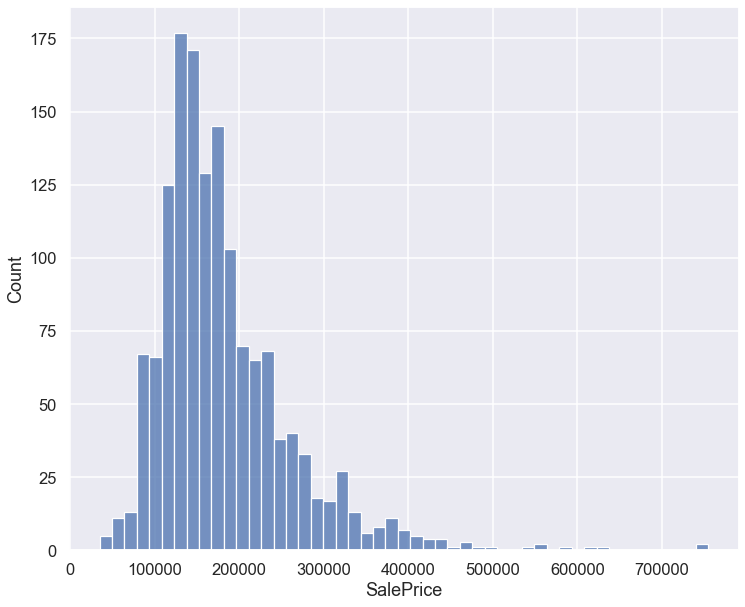

In [18]:
sns.set(rc={'figure.figsize': (12, 10)}, context='talk')
sns.histplot(x=train_data['SalePrice'])
plt.show()

Распределение очень похоже на логнормальное, значит его можно привести к нормальному взятием натурального логарифма от каждого значения.

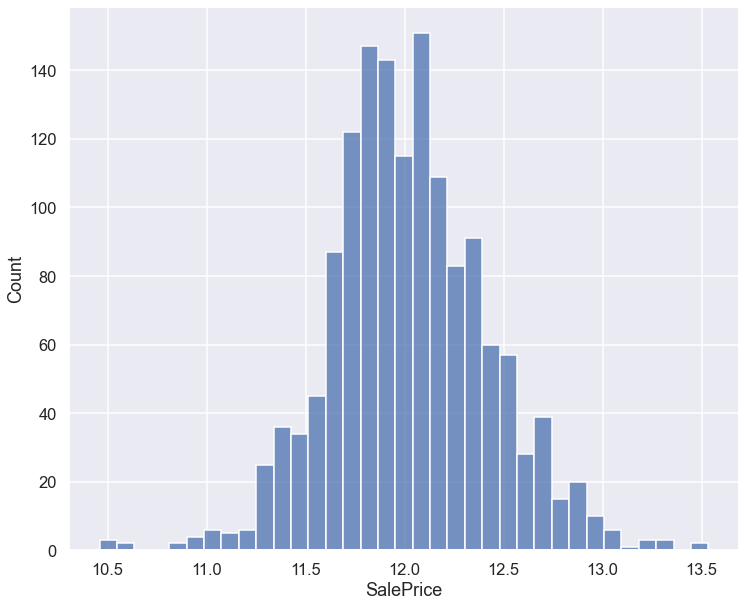

In [19]:
sns.histplot(x=train_data['SalePrice'].apply(np.log))
plt.show()

Распределение стало больше походить на нормальное, и к тому же мы устранили его очень длинный правый хвост, то есть в дальнейшем это сильно уменьшит влияние выбросов на модель.

Обработаем вручную некоторые признаки.

*MSSubClass* имеет числовые значения, хотя по описанию к датасетам, эти числа представляют собой категории.

In [20]:
for ds in full_data:
    ds['MSSubClass'] = ds['MSSubClass'].astype(str)

Узнаем диапазон значений в признаках, связанных с годами.

In [21]:
for ds in full_data:
    print('-'*10)
    print(ds['YearBuilt'].min(), ds['YearBuilt'].max())
    print(ds['YearRemodAdd'].min(), ds['YearRemodAdd'].max())
    print(ds['GarageYrBlt'].min(), ds['GarageYrBlt'].max())
    print(ds['YrSold'].min(), ds['YrSold'].max())
    print('-'*10)

----------
1872 2010
1950 2010
0.0 2010.0
2006 2010
----------
----------
1879 2010
1950 2010
0.0 2207.0
2006 2010
----------


В признаке *GarageYrBlt* очень странное максимальное значение. Проверим, единственное оно или нет.

In [22]:
test_data[test_data['GarageYrBlt'] > 0]['GarageYrBlt'].sort_values(ascending=False)

1132    2207.0
148     2010.0
42      2010.0
251     2009.0
201     2009.0
         ...  
1312    1900.0
790     1900.0
70      1900.0
142     1896.0
757     1895.0
Name: GarageYrBlt, Length: 1381, dtype: float64

Очевидно, это опечатка, и на месте этого значения должно быть **2007**.

In [23]:
test_data['GarageYrBlt'].iat[1132] = 2007

Чтобы уменьшить разброс будущей модели, переведём все года в десятилетия, которые будут являться категориями. Признаки *YrSold* и *MoSold* просто переведём в категории, т.к. они имеют малый диапазон значений.

In [24]:
def to_decades(x):
    if x.startswith('18'):
        x = 'XIX cent.'
    elif x.startswith('19'):
        for i in range(190, 200):
            if x.startswith(str(i)):
                x = str(i) + '0s'
    else:
        for i in range(200, 202):
            if x.startswith(str(i)):
                x = str(i) + '0s'
    return x

In [25]:
for ds in full_data:
    ds['YearBuilt'] = ds['YearBuilt'].astype(str).apply(to_decades)
    ds['YearRemodAdd'] = ds['YearRemodAdd'].astype(str).apply(to_decades)
    ds['GarageYrBlt'] = ds['GarageYrBlt'].astype(str).apply(to_decades)
    ds['YrSold'] = ds['YrSold'].astype(str)
    ds['MoSold'] = ds['MoSold'].astype(str)

Изучим графически все признаки, для чего напишем генератор, который будет при вызове отрисовывать по 9 последующих признаков.

In [26]:
feature_lists = np.array(train_data.columns).reshape(9, 3, 3)

In [27]:
def generate_plots(feature_lists):
    for lis in feature_lists:
        fig, axes = plt.subplots(*lis.shape, figsize=(25, 20))
        for irow, row in enumerate(lis):
            for icol, col in enumerate(row):
                if train_data[col].dtype != 'O':
                    sns.histplot(train_data, x=col, ax=axes[irow, icol])
                else:
                    sns.countplot(data=train_data, x=col, ax=axes[irow, icol])
        yield

In [28]:
gen = generate_plots(feature_lists)

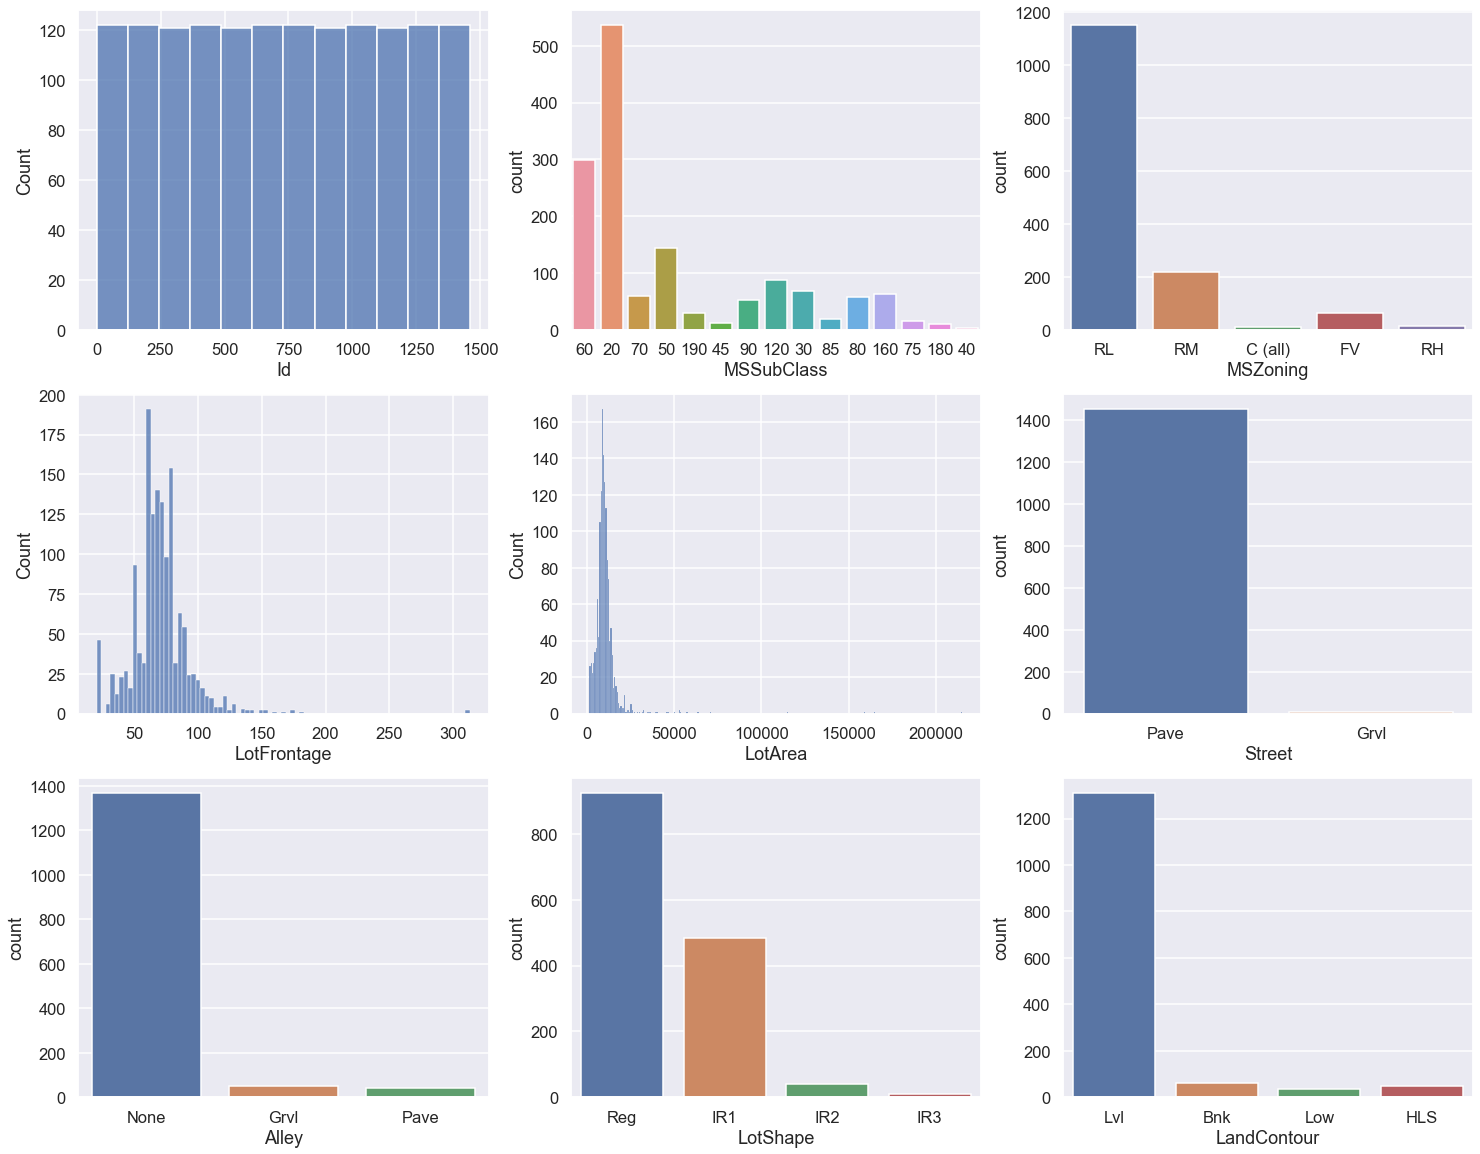

In [29]:
next(gen)

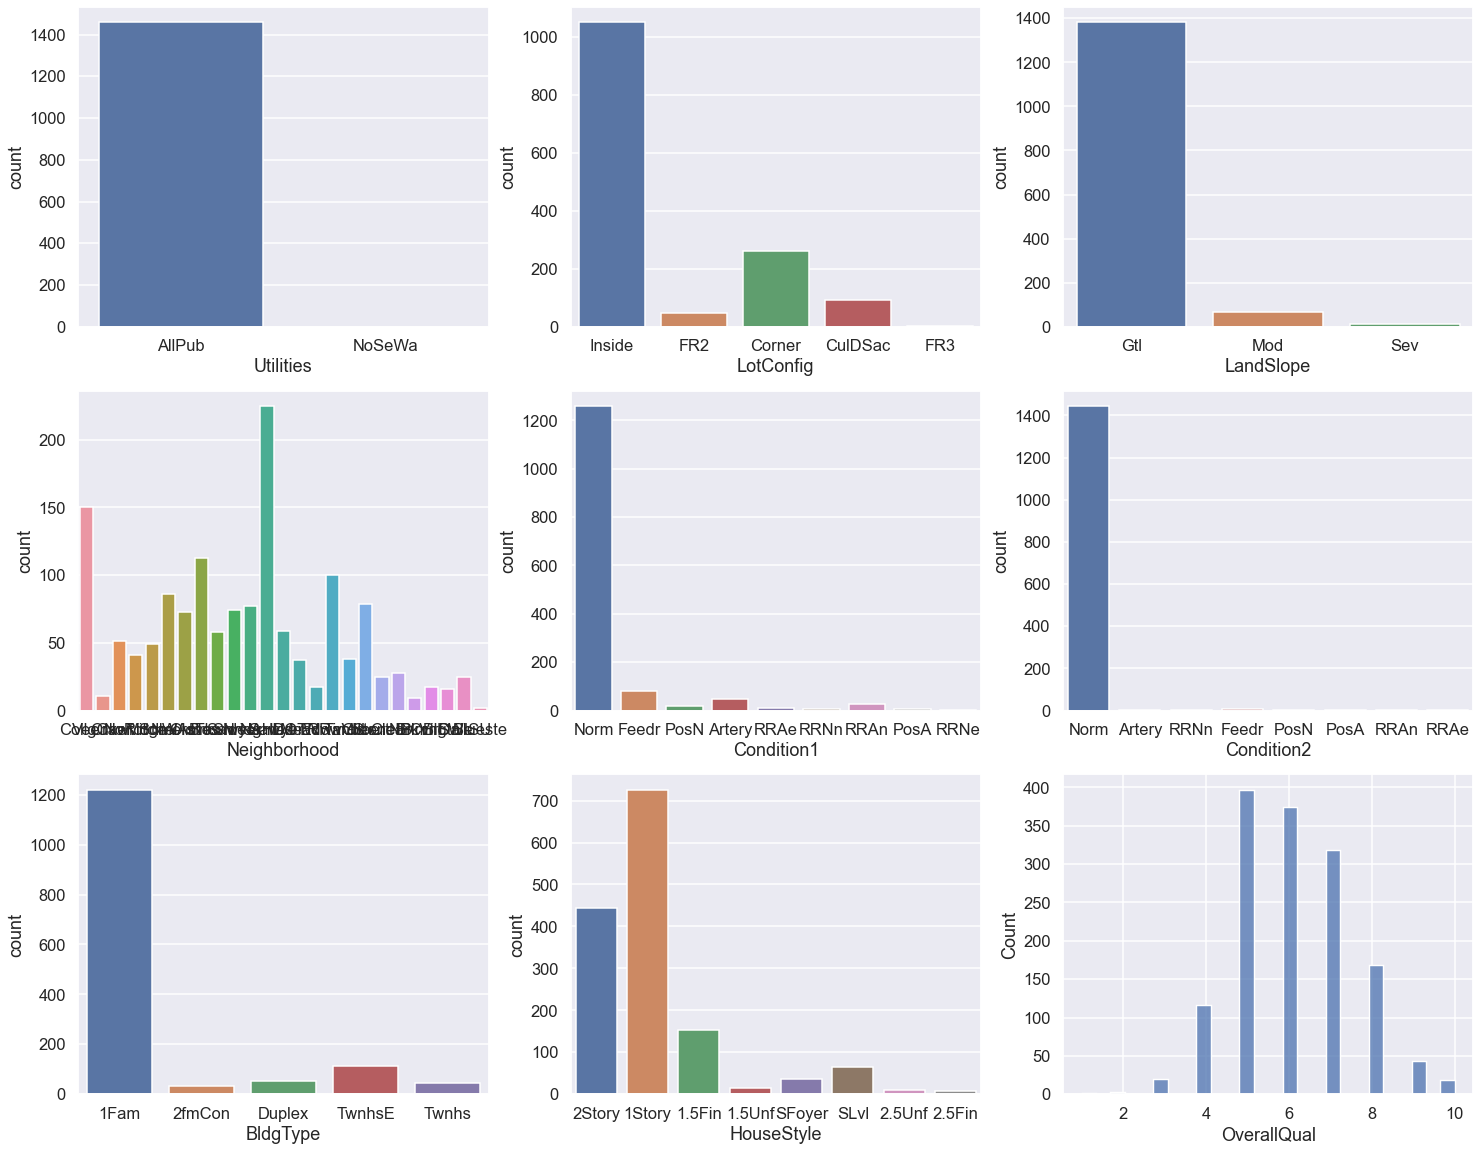

In [30]:
next(gen)

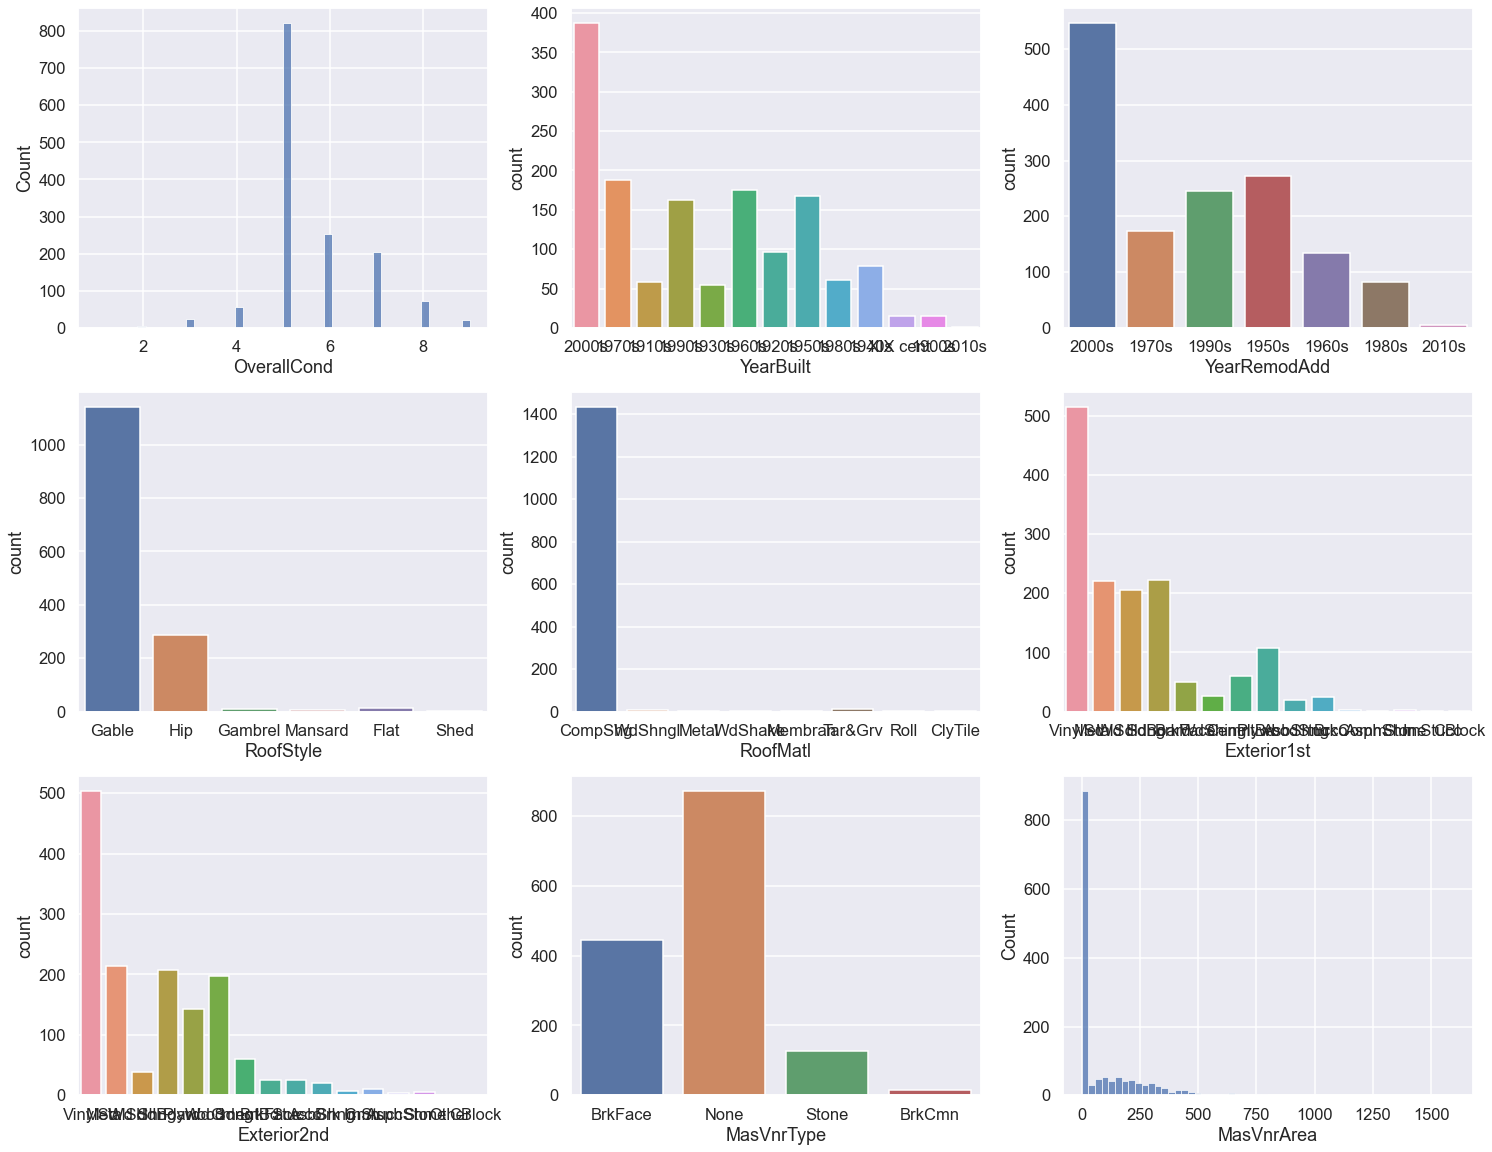

In [31]:
next(gen)

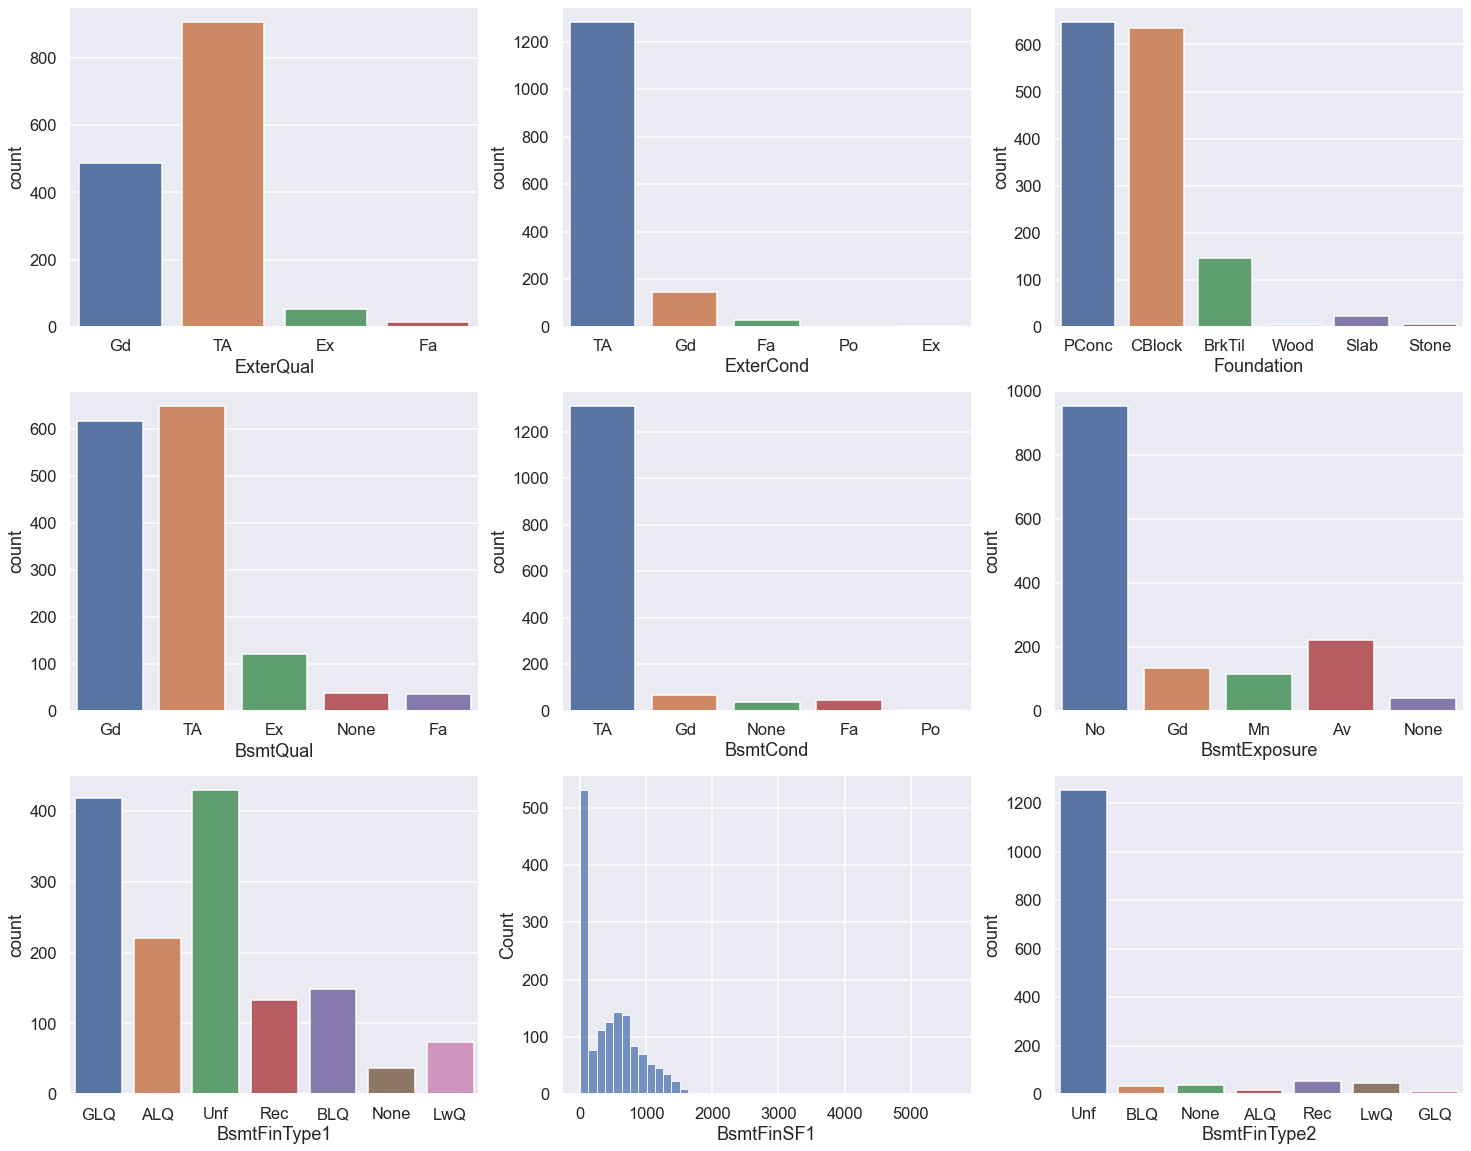

In [32]:
next(gen)

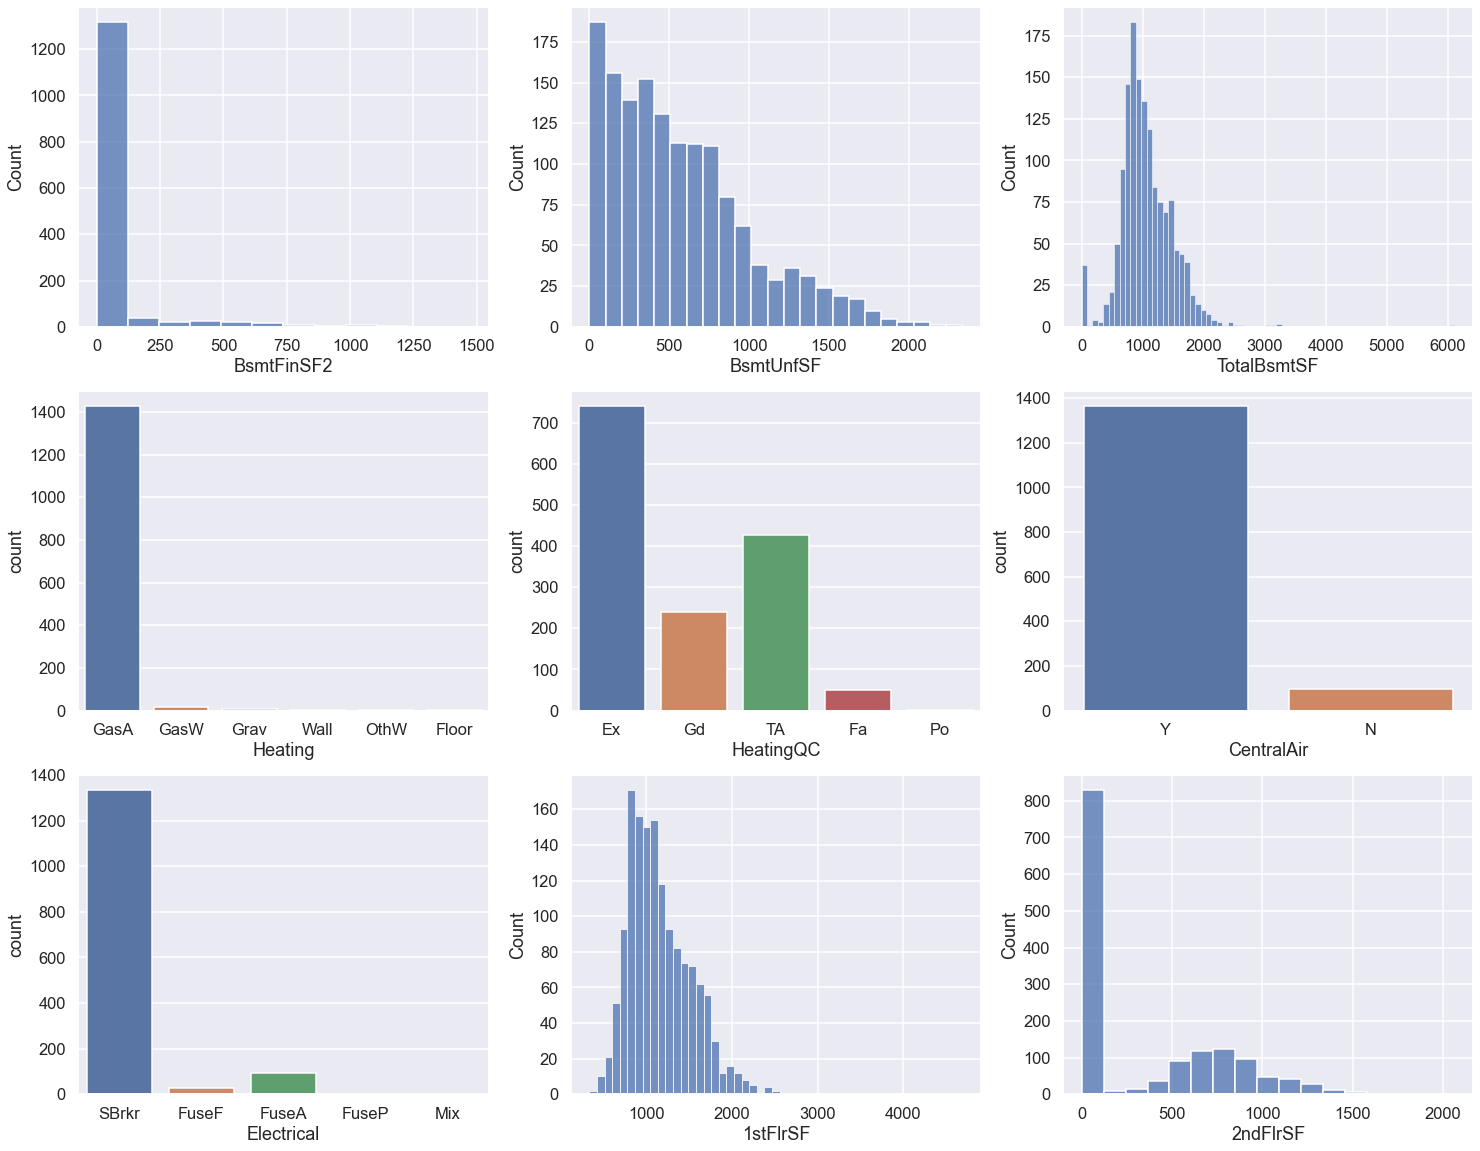

In [33]:
next(gen)

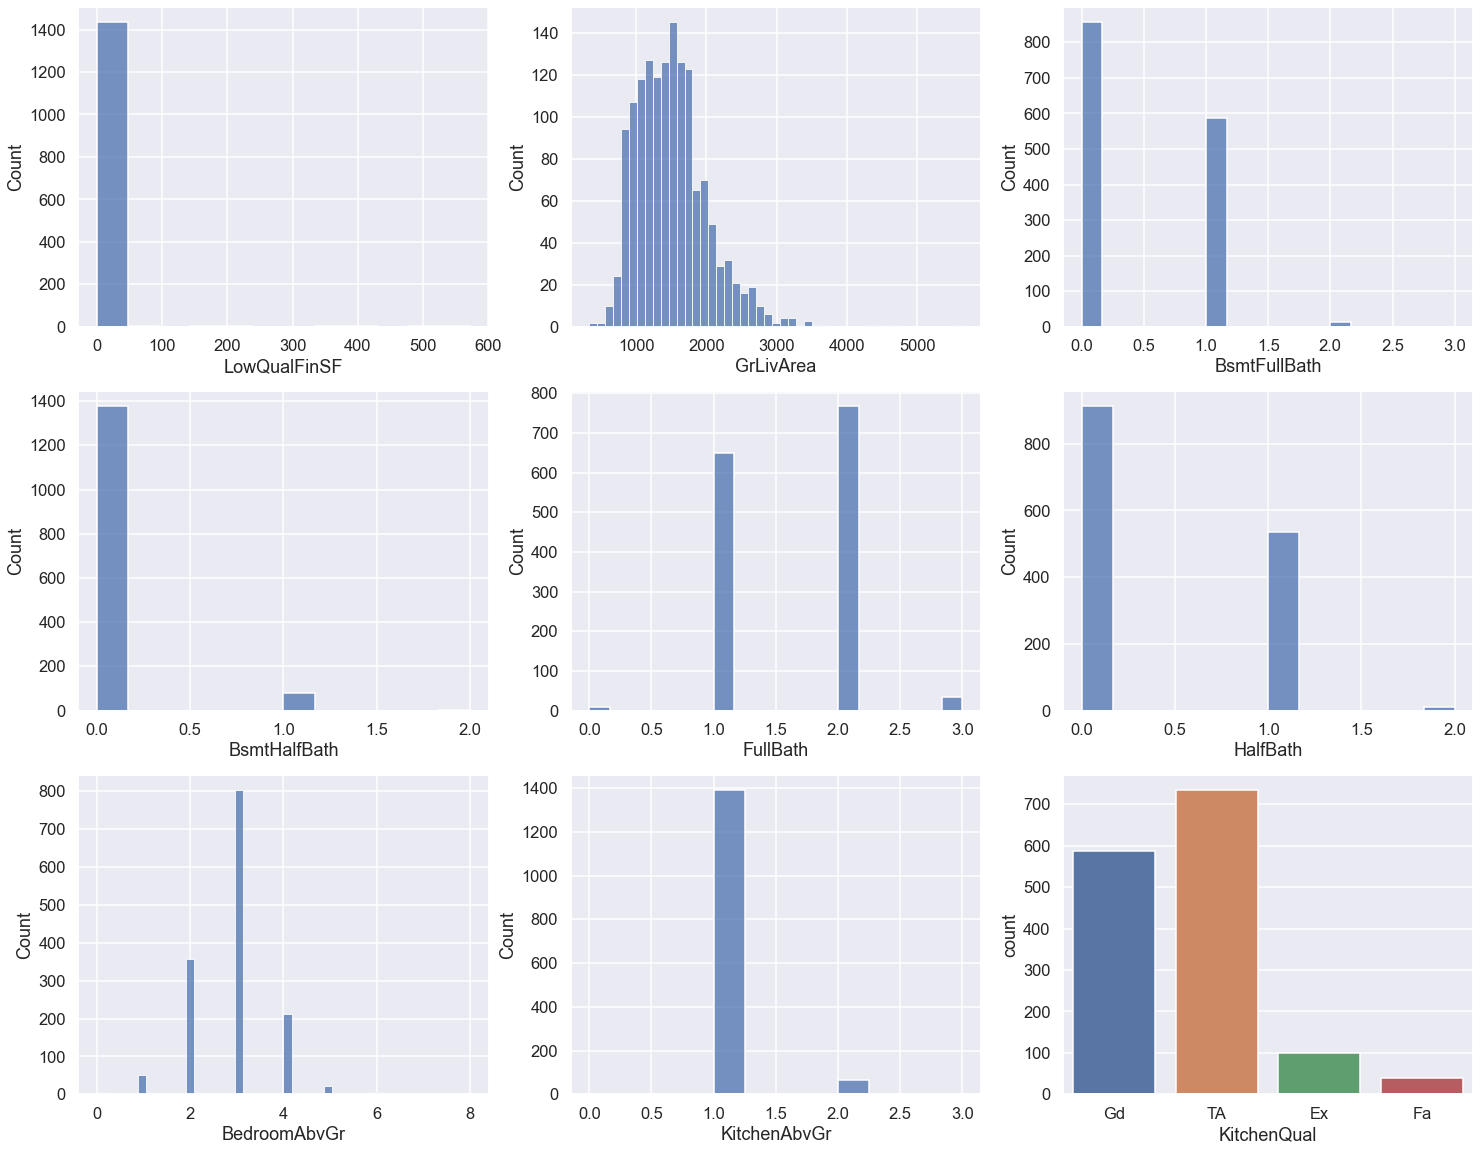

In [34]:
next(gen)

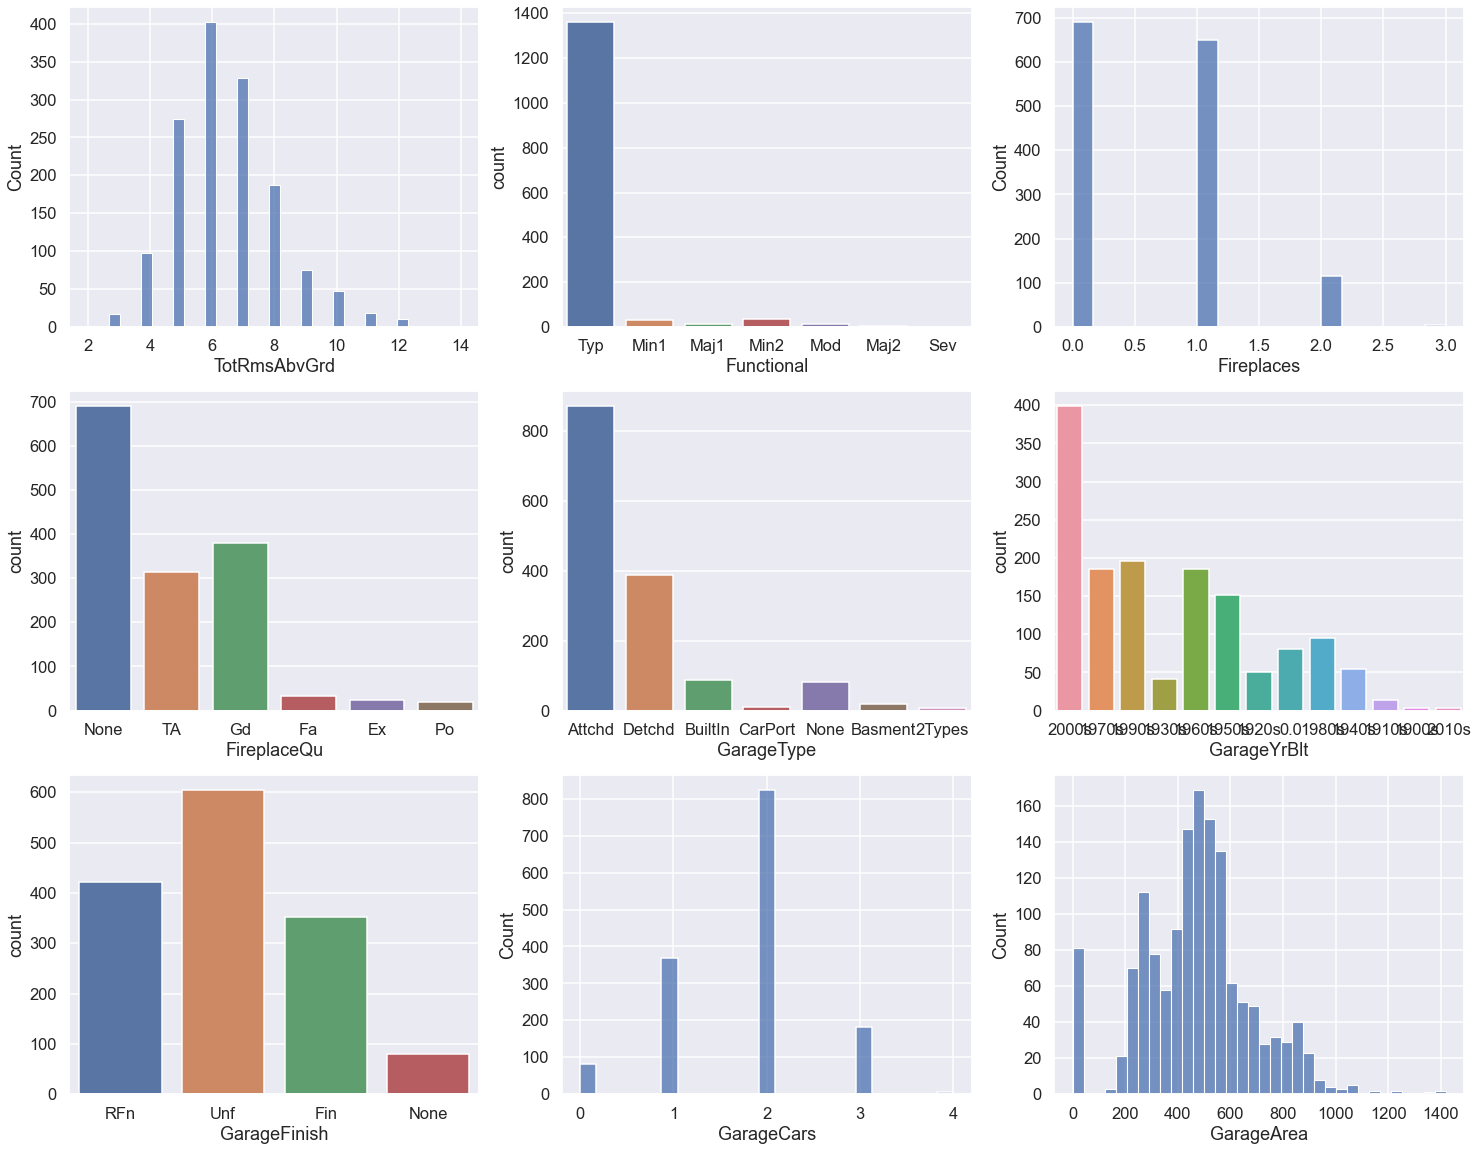

In [35]:
next(gen)

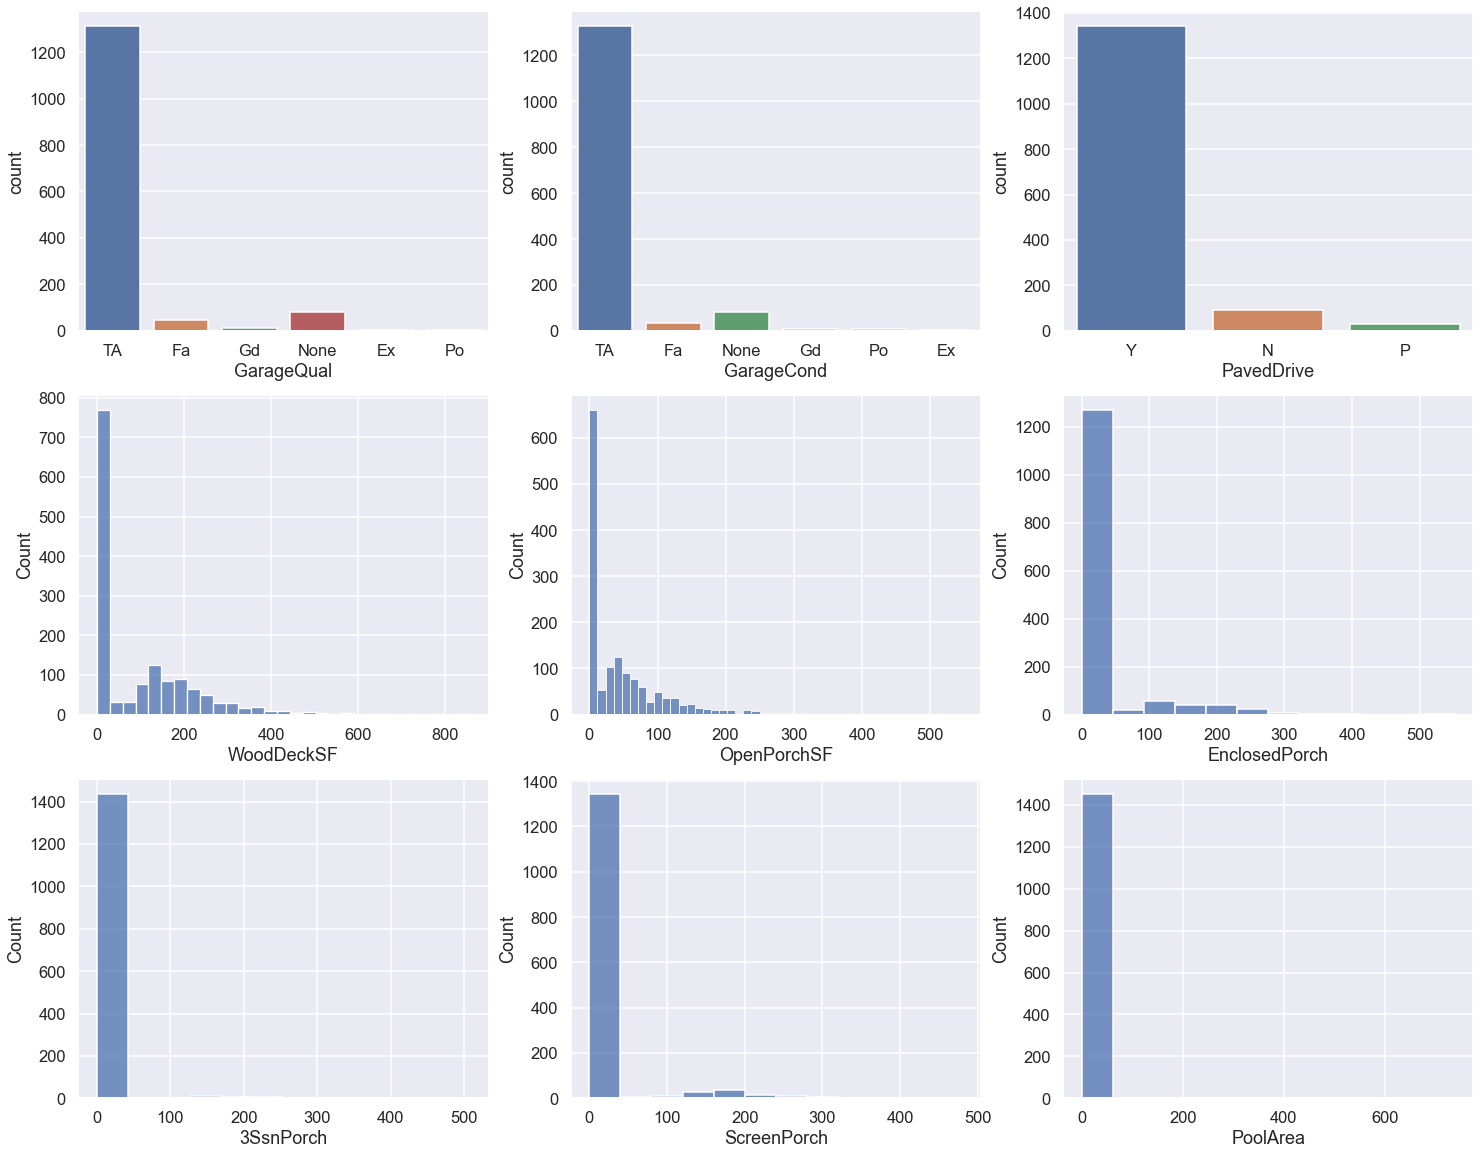

In [36]:
next(gen)

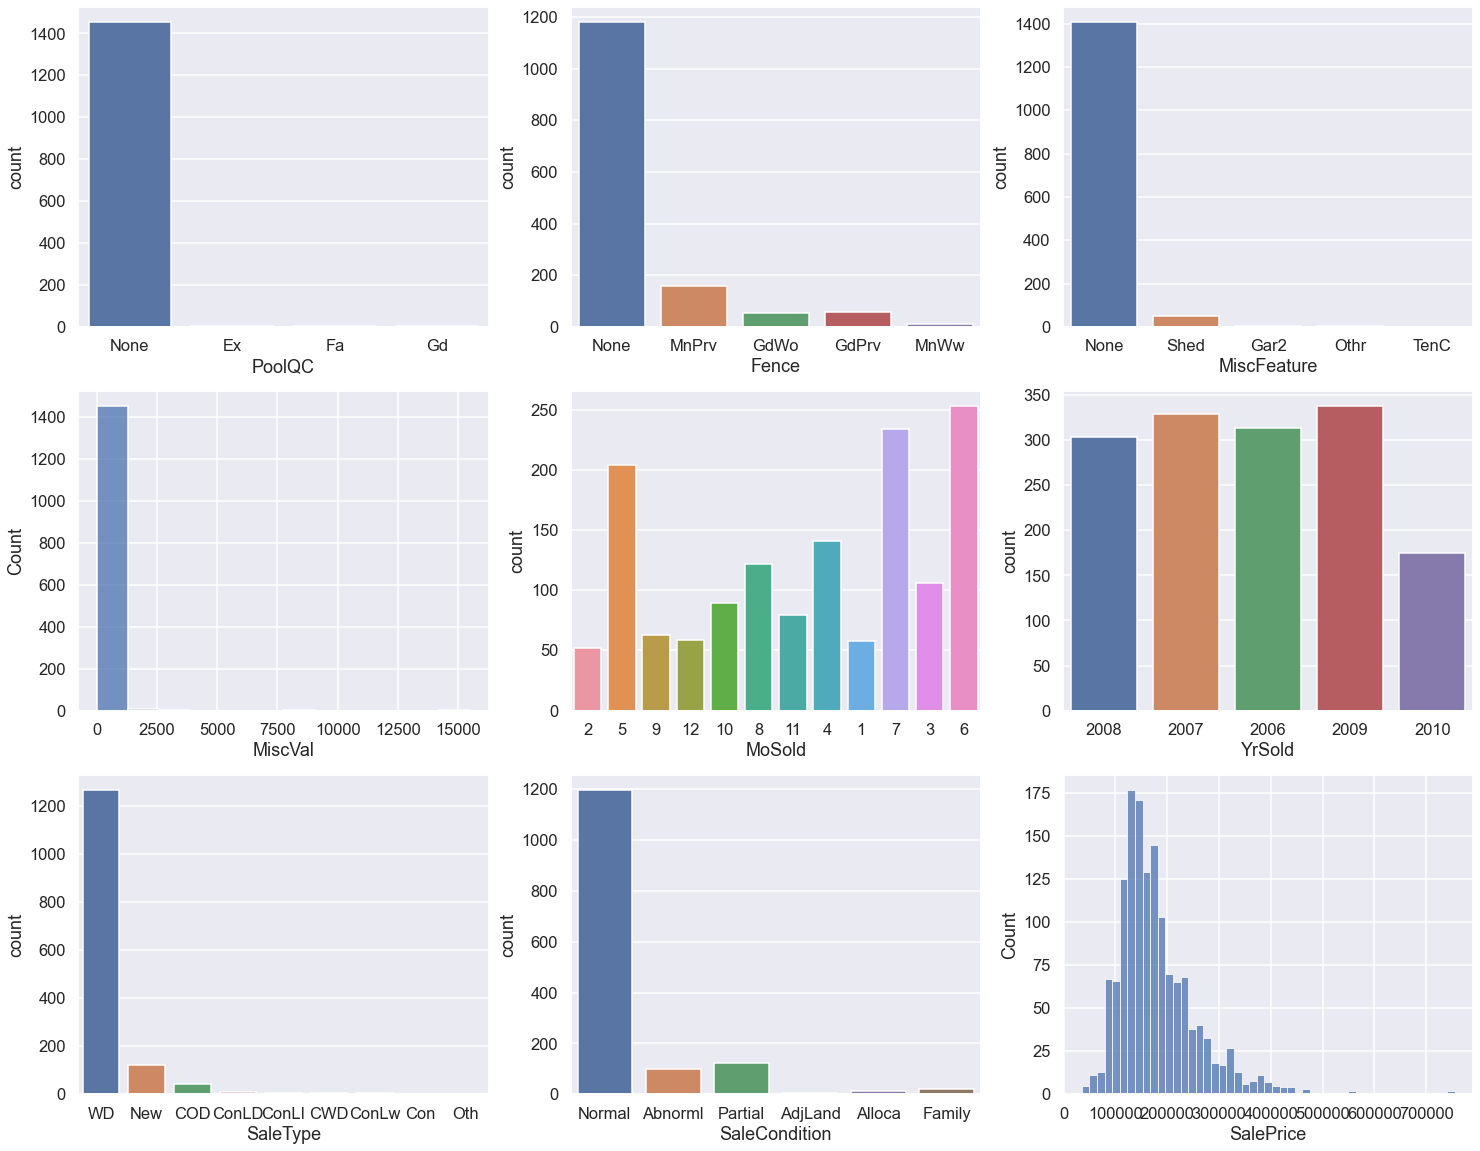

In [37]:
next(gen)

Как мы видим, почти все числовые признаки имеют распределения, схожие с логнормальным, и многие числовые признаки содержат значительные выбросы.
Среди категориальных признаков имеются таковые с очень малой изменчивостью.

Вместо дальнейшего "фича инжиниринга" перейдём сразу к машинному обучению, где будем применять модели с L1 регуляризацией (Lasso, Elastic Net).
L1 регуляризация примечательна тем, что модели с её применением способны обнулять малозначимые признаки датасета. Таким образом, снижается сложность модели, что влечёт за собой увеличение её смещённости (bias), и для снижения этой смещённости необходимо применить соответствующий ансамбль - бустинг.
Создадим стекинг, метамоделью которого будет градиентный бустинг, а в качестве базовых моделей будем использовать Lasso, Elastic Net и ещё один градиентный бустинг.

Нормализуем все числовые признаки с помощью натурального логарифма.

In [38]:
for ds in full_data:
    for num_feature in ds.select_dtypes(exclude='O').columns:
        ds[num_feature] = ds[num_feature].apply(np.log1p)

Удалим айди из датасетов.

In [39]:
for ds in full_data:
    ds.drop('Id', axis=1, inplace=True)

Объединим оба датасета для ***One-Hot*** кодирования категориальных признаков.

In [40]:
df = pd.concat(full_data).fillna(-1)
df = pd.get_dummies(df, dtype=np.int8)
df

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,2.079442,1.791759,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,1.945910,2.197225,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,2.079442,1.791759,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,2.079442,1.791759,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,2.197225,1.791759,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4.143135,7.568896,1.609438,2.079442,0.000000,0.000000,0.0,6.304449,6.304449,6.304449,...,0,0,0,1,0,0,0,0,1,0
1455,4.143135,7.546974,1.609438,1.791759,0.000000,5.533389,0.0,5.686975,6.304449,6.304449,...,0,0,0,1,1,0,0,0,0,0
1456,4.454347,9.903538,1.791759,2.079442,0.000000,7.110696,0.0,0.000000,7.110696,7.110696,...,0,0,0,1,1,0,0,0,0,0
1457,4.204693,9.253591,1.791759,1.791759,0.000000,5.823046,0.0,6.356108,6.816736,6.878326,...,0,0,0,1,0,0,0,0,1,0


Разделяем датасет на трейн, целевую переменную и тест.

In [41]:
X_train, y_train = df[df['SalePrice'] != -1].drop('SalePrice', axis=1), df[df['SalePrice'] != -1]['SalePrice']
X_test = df[df['SalePrice'] == -1].drop('SalePrice', axis=1).reset_index(drop=True)

Масштабируем выборки с помощью класса *RobustScaler*, который эффективно обрабатывает выбросы.

In [42]:
rs = RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_test_rs = rs.transform(X_test)

Создадим генератор для кросс-валидации.

In [43]:
kf = KFold(shuffle=True, random_state=42)

Найдём Lasso-модель с оптимальным коэффициентом регуляризации.

In [44]:
lasso_cv = GridSearchCV(Lasso(), dict(alpha=np.linspace(10**-4, 10**-3, 10, dtype=np.float32)), scoring='r2', n_jobs=-1, cv=kf)
lasso_cv.fit(X_train_rs, y_train)
lasso_cv.best_params_

{'alpha': 0.0004}

Делаем то же самое для Elastic Net, только теперь нам необходимо ещё подобрать параметр *l1_ratio*, который определяет степень использования L1 и L2 регуляризаций.

In [45]:
enet_cv = GridSearchCV(ElasticNet(), dict(alpha=np.linspace(10**-4, 10**-3, 10, dtype=np.float32),
                                          l1_ratio=np.linspace(0, 1, 10, dtype=np.float32)),
                       scoring='r2', n_jobs=-1, cv=kf)
enet_cv.fit(X_train_rs, y_train)
enet_cv.best_params_

{'alpha': 0.0004, 'l1_ratio': 1.0}

Теперь градиентный бустинг.

In [46]:
params = dict(max_depth=[5, 6, 7], alpha=np.linspace(0.1, 1, 10, dtype=np.float32),
              reg_lambda=np.linspace(0.001, 0.01, 10, dtype=np.float32))
xgbr_cv = GridSearchCV(XGBRegressor(n_estimators=100, eta=0.1, random_state=42, colsample_bytree=1/3), params,
                       scoring='neg_root_mean_squared_error', n_jobs=-1, cv=kf)
xgbr_cv.fit(X_train_rs, y_train)
xgbr_cv.best_params_

{'alpha': 0.1, 'max_depth': 6, 'reg_lambda': 0.003}

Создаём стекинг, где в качестве метамодели будем использовать точно такую же, как обученный только что бустинг.

In [47]:
base_models = [
    ('lasso', lasso_cv.best_estimator_),
    ('enet', enet_cv.best_estimator_),
    ('xgbr', xgbr_cv.best_estimator_)
]
meta_model = XGBRegressor(n_estimators=100, eta=0.1, random_state=42, colsample_bytree=1/3, **xgbr_cv.best_params_)
stack = StackingRegressor(base_models, meta_model, cv=kf, n_jobs=-1, passthrough=True)
stack.fit(X_train_rs, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                  estimators=[('lasso', Lasso(alpha=0.0004)),
                              ('enet', ElasticNet(alpha=0.0004, l1_ratio=1.0)),
                              ('xgbr',
                               XGBRegressor(alpha=0.1, base_score=0.5,
                                            booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.3333333333333333,
                                            eta=0.1, gamma=0, gpu_id=-1,
                                            importance_type='gain',
                                            intera...
                                               interaction_constraints=None,
                                               learning_rate=None,
                                               max_delta_step=None

Посмотрим на **RMSE** модели на кросс-валидации.

In [48]:
np.abs(cross_val_score(stack, X_train_rs, y_train, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1).mean())

0.12959575312575125

Делаем предсказания для тестового датасета. Так как мы обучили модель предсказывать значение натурального логарифма стоимости дома, для конвертации обратно в стоимость необходимо произвести потенцирование предсказаний.

In [49]:
decision = pd.DataFrame({'Id': Id, 'SalePrice': np.expm1(stack.predict(X_test_rs))})
decision

,Id,SalePrice
0,1461,124132.468750
1,1462,161594.296875
2,1463,179835.250000
3,1464,196055.125000
4,1465,194869.203125
...,...,...
1454,2915,81455.945312
1455,2916,85838.062500
1456,2917,159885.531250
1457,2918,113077.718750


Сохраняем предсказания.

In [50]:
decision.to_csv('Путь для сохранения и название файла', index=False)